<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/class3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# --------------------------------------------------------------------
# 데이터 로드
# --------------------------------------------------------------------
path = '/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "trash"]

df = pd.read_csv(path, header=None, names=names, comment=";", engine="python", on_bad_lines="skip")


<Axes: xlabel='activity', ylabel='count'>

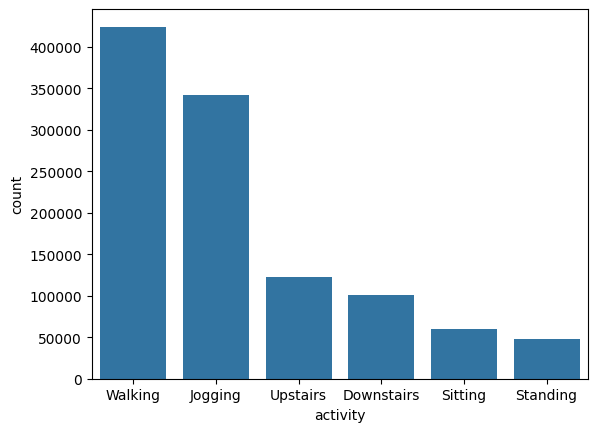

In [ ]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

In [ ]:
df['activity'].value_counts()

,count
activity,
Walking,424397
Jogging,342176
Upstairs,122869
Downstairs,100427
Sitting,59939
Standing,48395


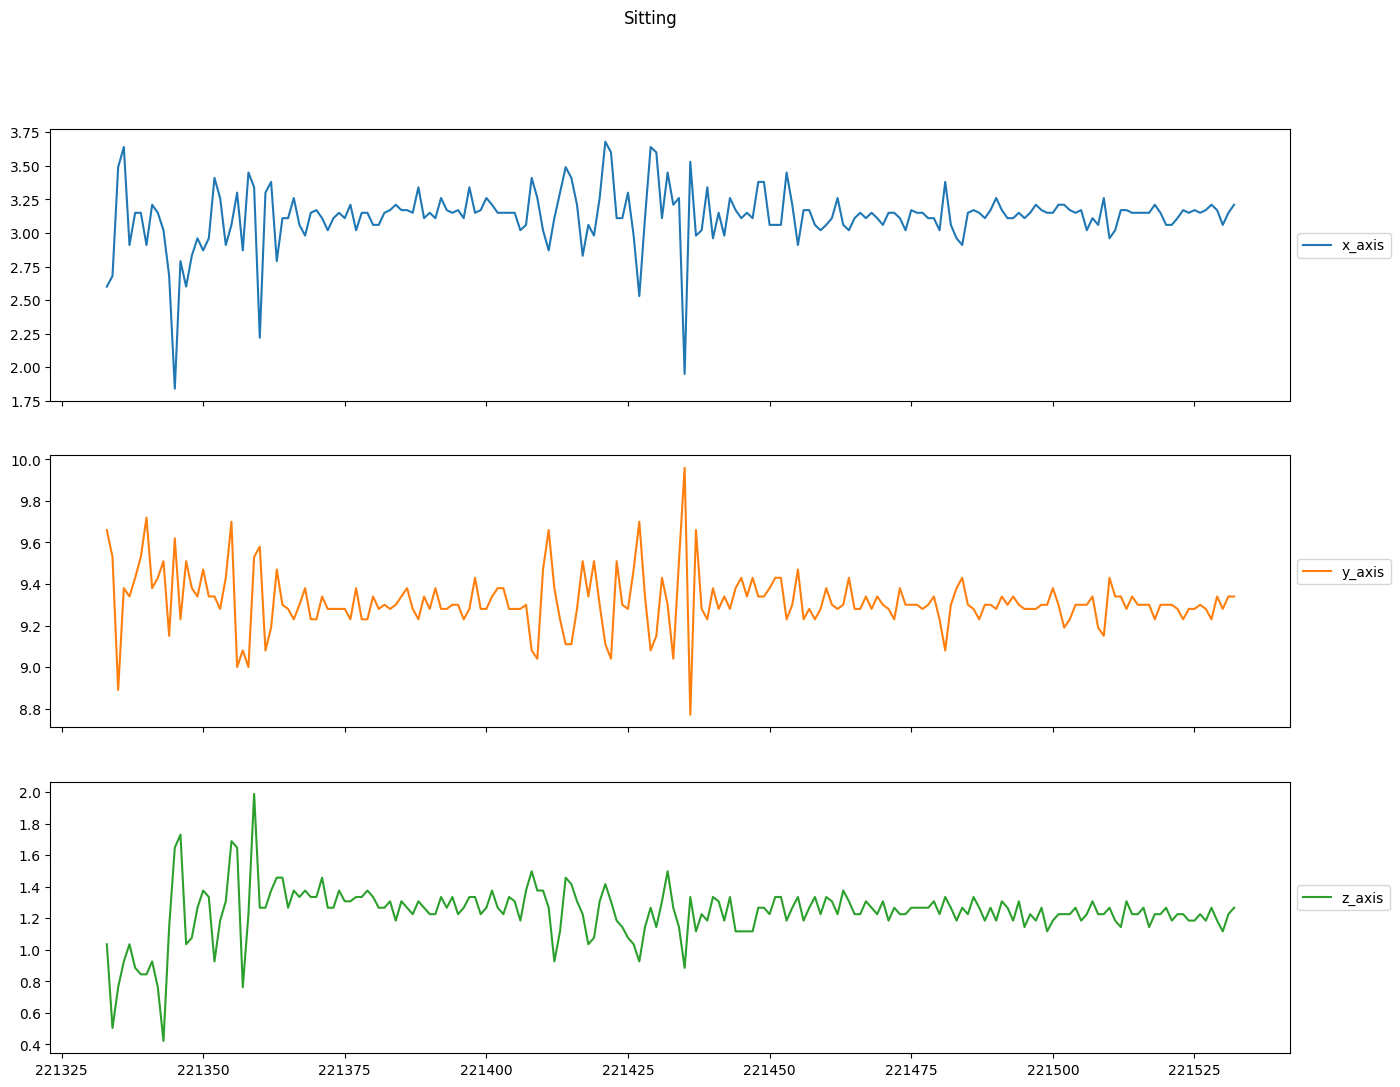

In [ ]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)

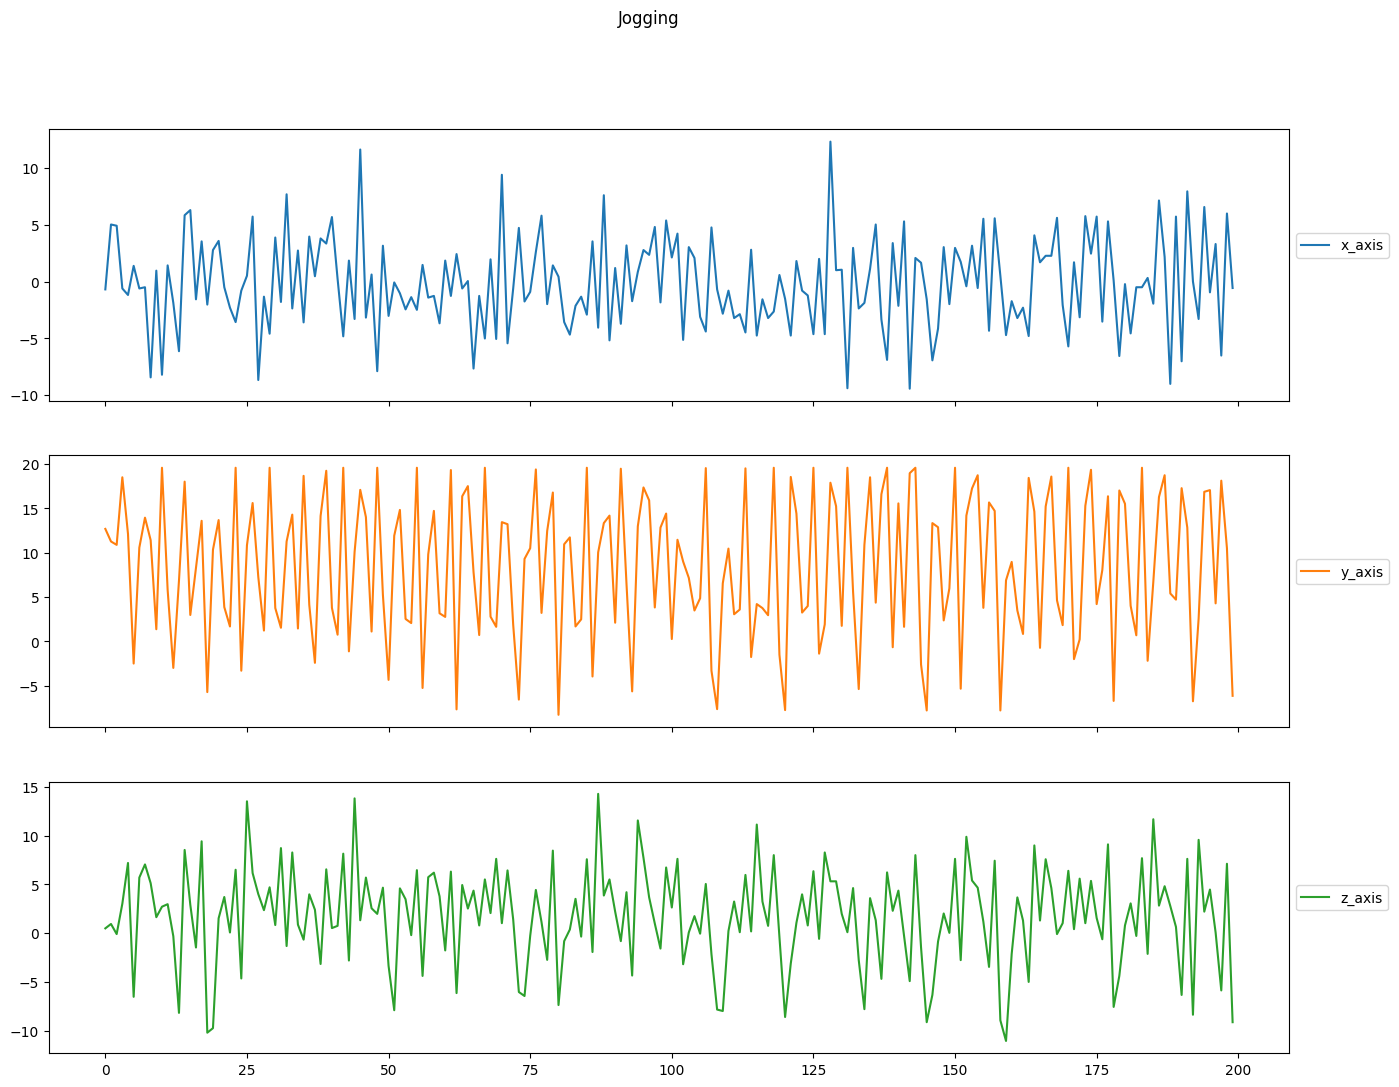

In [ ]:
plot_activity("Jogging", df)

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
df['user_id'].nunique()

36

In [ ]:
# z축 끝 세미콜론 제거 + 수치 변환
df["z_axis"] = pd.to_numeric(df["z_axis"].astype(str).str.replace(";", "", regex=False), errors="coerce")

# 결측 제거
df.dropna(subset=["x_axis","y_axis","z_axis","activity"], inplace=True)

# 필요 없는 열 제거
if "trash" in df.columns:
    df.drop(columns=["trash"], inplace=True)

# 타입 정리
df["user_id"] = df["user_id"].astype(int)
df = df.reset_index(drop=True)

print(df.head())
print(df["activity"].value_counts())

   user_id activity       timestamp    x_axis     y_axis    z_axis
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164
activity
Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64


In [ ]:
# ===== 사람 단위 분할(데이터 누수 방지) =====
df_train = df[df["user_id"] <= 30].reset_index(drop=True)
df_test  = df[df["user_id"] > 30].reset_index(drop=True)

print("Train users:", df_train["user_id"].nunique(),
      "| Test users:", df_test["user_id"].nunique())

print(df_train["activity"].value_counts(), "\n")
print(df_test["activity"].value_counts())

Train users: 30 | Test users: 6
activity
Walking       353508
Jogging       275439
Upstairs      102810
Downstairs     82634
Sitting        45810
Standing       38159
Name: count, dtype: int64 

activity
Walking       70889
Jogging       66737
Upstairs      20059
Downstairs    17793
Sitting       14129
Standing      10236
Name: count, dtype: int64


In [ ]:
# ===== 슬라이딩 윈도우 함수 (mode 경고 없이, 축 안전) =====
def make_windows(df, time_steps=200, step=40, label_col="activity"):
    Xs, ys = [], []
    X_all = df[["x_axis","y_axis","z_axis"]].values
    y_all = df[label_col].values
    L = len(df)
    for start in range(0, L - time_steps, step):
        end = start + time_steps
        win = X_all[start:end].astype(np.float32)                 # (T, 3)
        lab = Series(y_all[start:end]).mode().iloc[0]             # 최빈값
        Xs.append(win); ys.append(lab)
    if not Xs:
        return np.empty((0, time_steps, 3), np.float32), np.array([], dtype=object)
    return np.stack(Xs, axis=0), np.array(ys)

TIME_STEPS = 200
STEP = 40

X_train, y_train_raw = make_windows(df_train, TIME_STEPS, STEP, "activity")
X_test,  y_test_raw  = make_windows(df_test,  TIME_STEPS, STEP, "activity")

print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("예: y_train_raw[:5] ->", y_train_raw[:5])

X_train: (22454, 200, 3) | X_test: (4992, 200, 3)
예: y_train_raw[:5] -> ['Walking' 'Walking' 'Walking' 'Walking' 'Walking']


In [ ]:
# ===== 스케일링 =====
scaler = StandardScaler()
N, T, F = X_train.shape
X_train = scaler.fit_transform(X_train.reshape(-1, F)).reshape(N, T, F).astype(np.float32)
X_test  = scaler.transform(X_test.reshape(-1, F)).reshape(X_test.shape[0], T, F).astype(np.float32)


In [ ]:
# ===== 인코딩 =====
try:
    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

y_train = enc.fit_transform(y_train_raw.reshape(-1,1))
y_test  = enc.transform(y_test_raw.reshape(-1,1))
class_names = enc.categories_[0]
n_outputs = y_train.shape[1]

print("Classes:", class_names)
print("y_train shape:", y_train.shape, "| y_test shape:", y_test.shape)

Classes: ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']
y_train shape: (22454, 6) | y_test shape: (4992, 6)


In [ ]:
# ===== 검증 분할 =====
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)
X_tr.shape, X_val.shape


((17963, 200, 3), (4491, 200, 3))

In [ ]:
# =====CNN 모델 =====
def build_cnn(input_shape, n_classes):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(96, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(n_classes, activation="softmax")(x)
    return models.Model(inp, out, name="CNN_1D")

input_shape = (TIME_STEPS, 3)
model = build_cnn(input_shape, n_outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "CNN_1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 96)        │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 96)        │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 32)         │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,766 (116.27 KB)

 Trainable params: 29,382 (114.77 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# ===== 학습 =====
early  = callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
reduce = callbacks.ReduceLROnPlateau(patience=4, factor=0.5, min_lr=1e-5)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=256,
    callbacks=[early, reduce],
    verbose=2
)


Epoch 1/40
71/71 - 28s - 392ms/step - accuracy: 0.7684 - loss: 0.7078 - val_accuracy: 0.4237 - val_loss: 1.6033 - learning_rate: 1.0000e-03
Epoch 2/40
71/71 - 35s - 489ms/step - accuracy: 0.9270 - loss: 0.2436 - val_accuracy: 0.3674 - val_loss: 1.8556 - learning_rate: 1.0000e-03
Epoch 3/40
71/71 - 21s - 302ms/step - accuracy: 0.9587 - loss: 0.1499 - val_accuracy: 0.4184 - val_loss: 1.8664 - learning_rate: 1.0000e-03
Epoch 4/40
71/71 - 19s - 269ms/step - accuracy: 0.9698 - loss: 0.1102 - val_accuracy: 0.5197 - val_loss: 1.2598 - learning_rate: 1.0000e-03
Epoch 5/40
71/71 - 19s - 267ms/step - accuracy: 0.9765 - loss: 0.0863 - val_accuracy: 0.8493 - val_loss: 0.4935 - learning_rate: 1.0000e-03
Epoch 6/40
71/71 - 18s - 255ms/step - accuracy: 0.9817 - loss: 0.0682 - val_accuracy: 0.9742 - val_loss: 0.1235 - learning_rate: 1.0000e-03
Epoch 7/40
71/71 - 23s - 320ms/step - accuracy: 0.9814 - loss: 0.0634 - val_accuracy: 0.9837 - val_loss: 0.0603 - learning_rate: 1.0000e-03
Epoch 8/40
71/71 - 1

Test Acc: 94.13% | Test Loss: 0.192
              precision    recall  f1-score   support

  Downstairs     0.7909    0.8991    0.8416       446
     Jogging     0.9908    0.9629    0.9766      1669
     Sitting     0.9291    1.0000    0.9633       354
    Standing     0.9854    0.8016    0.8840       252
    Upstairs     0.8429    0.8480    0.8455       500
     Walking     0.9645    0.9661    0.9653      1771

    accuracy                         0.9413      4992
   macro avg     0.9173    0.9129    0.9127      4992
weighted avg     0.9441    0.9413    0.9418      4992



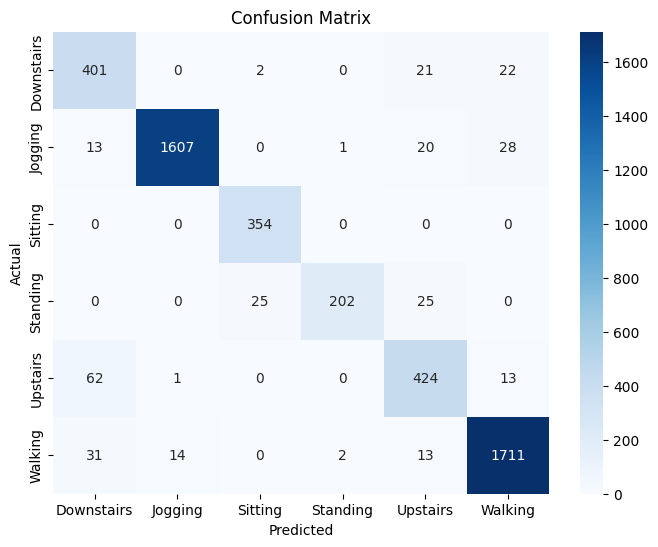

In [ ]:
# ===== 평가 & 혼동행렬 =====
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
print(f"Test Acc: {test_acc*100:.2f}% | Test Loss: {test_loss:.3f}")

y_prob = model.predict(X_test, batch_size=256, verbose=0)
y_pred_idx = np.argmax(y_prob, axis=1)
y_true_idx = np.argmax(y_test, axis=1)

print(classification_report(y_true_idx, y_pred_idx, target_names=class_names, digits=4))

cm = confusion_matrix(y_true_idx, y_pred_idx)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("Actual"); plt.xlabel("Predicted"); plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import callbacks

# 클래스 일관성을 위해 전체 데이터의 activity로 OneHotEncoder를 미리 고정
try:
    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

enc.fit(df["activity"].values.reshape(-1,1))
class_names = enc.categories_[0]
n_classes = len(class_names)
print("Classes:", class_names)


Classes: ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']


In [ ]:
K = 5
TIME_STEPS = 200
STEP = 40
input_shape = (TIME_STEPS, 3)

gkf = GroupKFold(n_splits=K)
groups = df_train["user_id"].values
idx = np.arange(len(df_train))

fold_results = []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(idx, groups=groups), start=1):
    print(f"\n========== Fold {fold}/{K} ==========")
    df_tr = df_train.iloc[tr_idx].reset_index(drop=True)
    df_va = df_train.iloc[va_idx].reset_index(drop=True)

    # 1) 윈도우 생성
    X_tr_win, y_tr_raw = make_windows(df_tr, time_steps=TIME_STEPS, step=STEP, label_col="activity")
    X_va_win, y_va_raw = make_windows(df_va, time_steps=TIME_STEPS, step=STEP, label_col="activity")

    if len(X_tr_win)==0 or len(X_va_win)==0:
        print("윈도우가 부족하여 이 fold는 건너뜁니다.")
        continue

    # 2) 스케일링 (train으로 fit → train/val transform)
    scaler = StandardScaler()
    Nt,T,F = X_tr_win.shape
    X_tr_win = scaler.fit_transform(X_tr_win.reshape(-1, F)).reshape(Nt, T, F).astype(np.float32)
    X_va_win = scaler.transform(X_va_win.reshape(-1, F)).reshape(X_va_win.shape[0], T, F).astype(np.float32)

    # 3) 라벨 원-핫 (전체 클래스 체계 enc 사용)
    y_tr = enc.transform(y_tr_raw.reshape(-1,1))
    y_va = enc.transform(y_va_raw.reshape(-1,1))

    # 4) 모델 생성/컴파일
    model = build_cnn(input_shape, n_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])

    # 5) 콜백
    early  = callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor="val_loss")
    reduce = callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)

    # 6) 학습
    hist = model.fit(
        X_tr_win, y_tr,
        validation_data=(X_va_win, y_va),
        epochs=40, batch_size=256, verbose=2,
        callbacks=[early, reduce]
    )

    # 7) 검증 평가(accuracy, macro-F1)
    y_va_prob = model.predict(X_va_win, batch_size=256, verbose=0)
    y_va_pred = np.argmax(y_va_prob, axis=1)
    y_va_true = np.argmax(y_va, axis=1)

    acc = accuracy_score(y_va_true, y_va_pred)
    f1m = f1_score(y_va_true, y_va_pred, average="macro")

    print(f"[Fold {fold}] Val Acc: {acc*100:.2f}% | Macro-F1: {f1m:.4f}")
    fold_results.append({"fold": fold, "val_acc": acc, "val_f1_macro": f1m})



========== Fold 1/5 ==========
Epoch 1/40
70/70 - 22s - 318ms/step - accuracy: 0.8155 - loss: 0.5912 - val_accuracy: 0.6265 - val_loss: 1.3587 - learning_rate: 1.0000e-03
Epoch 2/40
70/70 - 19s - 267ms/step - accuracy: 0.9470 - loss: 0.1993 - val_accuracy: 0.4934 - val_loss: 1.4205 - learning_rate: 1.0000e-03
Epoch 3/40
70/70 - 22s - 311ms/step - accuracy: 0.9721 - loss: 0.1161 - val_accuracy: 0.5593 - val_loss: 1.2977 - learning_rate: 1.0000e-03
Epoch 4/40
70/70 - 19s - 268ms/step - accuracy: 0.9780 - loss: 0.0850 - val_accuracy: 0.6863 - val_loss: 0.9846 - learning_rate: 1.0000e-03
Epoch 5/40
70/70 - 19s - 266ms/step - accuracy: 0.9814 - loss: 0.0706 - val_accuracy: 0.7857 - val_loss: 0.7833 - learning_rate: 1.0000e-03
Epoch 6/40
70/70 - 21s - 294ms/step - accuracy: 0.9838 - loss: 0.0576 - val_accuracy: 0.8554 - val_loss: 0.6366 - learning_rate: 1.0000e-03
Epoch 7/40
70/70 - 20s - 290ms/step - accuracy: 0.9856 - loss: 0.0510 - val_accuracy: 0.8686 - val_loss: 0.6462 - learning_rate:

In [ ]:
import pandas as pd
cv_df = pd.DataFrame(fold_results)
print("\n=== CV Results ===")
print(cv_df)
print("\nMean Acc:  {:.2f}%".format(cv_df["val_acc"].mean()*100))
print("Mean F1m:  {:.4f}".format(cv_df["val_f1_macro"].mean()))
print("Std Acc:   {:.2f}%".format(cv_df["val_acc"].std()*100))
print("Std F1m:   {:.4f}".format(cv_df["val_f1_macro"].std()))



=== CV Results ===
   fold   val_acc  val_f1_macro
0     1  0.886905      0.865077
1     2  0.766272      0.654905
2     3  0.822470      0.805086
3     4  0.924578      0.906986
4     5  0.841597      0.837870

Mean Acc:  84.84%
Mean F1m:  0.8140
Std Acc:   6.07%
Std F1m:   0.0965


Epoch 1/40
79/79 - 24s - 300ms/step - accuracy: 0.8091 - loss: 0.5732 - val_accuracy: 0.5245 - val_loss: 1.5975 - learning_rate: 1.0000e-03
Epoch 2/40
79/79 - 40s - 512ms/step - accuracy: 0.9450 - loss: 0.1947 - val_accuracy: 0.3183 - val_loss: 1.7965 - learning_rate: 1.0000e-03
Epoch 3/40
79/79 - 22s - 283ms/step - accuracy: 0.9654 - loss: 0.1226 - val_accuracy: 0.5739 - val_loss: 1.3478 - learning_rate: 1.0000e-03
Epoch 4/40
79/79 - 41s - 515ms/step - accuracy: 0.9749 - loss: 0.0893 - val_accuracy: 0.7418 - val_loss: 0.7851 - learning_rate: 1.0000e-03
Epoch 5/40
79/79 - 41s - 523ms/step - accuracy: 0.9809 - loss: 0.0689 - val_accuracy: 0.8500 - val_loss: 0.4187 - learning_rate: 1.0000e-03
Epoch 6/40
79/79 - 20s - 257ms/step - accuracy: 0.9830 - loss: 0.0593 - val_accuracy: 0.8718 - val_loss: 0.3305 - learning_rate: 1.0000e-03
Epoch 7/40
79/79 - 22s - 279ms/step - accuracy: 0.9848 - loss: 0.0531 - val_accuracy: 0.8393 - val_loss: 0.5331 - learning_rate: 1.0000e-03
Epoch 8/40
79/79 - 2

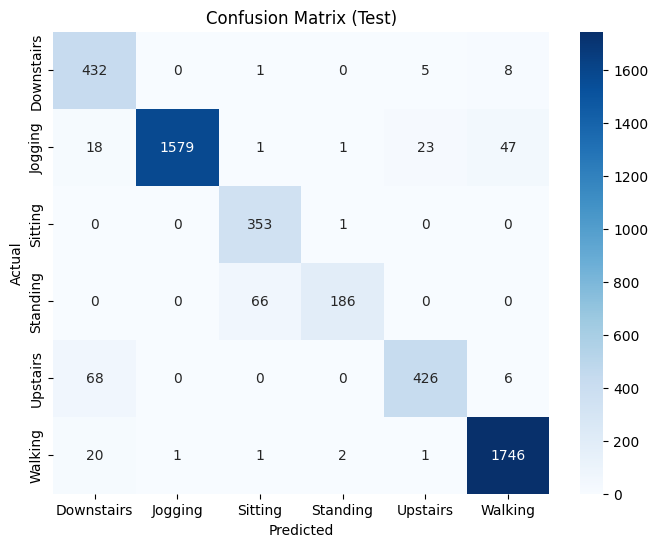

In [ ]:
# 윈도우 (train 전체 / test 전체)
X_tr_all, y_tr_all_raw = make_windows(df_train, time_steps=TIME_STEPS, step=STEP, label_col="activity")
X_te_all, y_te_all_raw = make_windows(df_test,  time_steps=TIME_STEPS, step=STEP, label_col="activity")

# 스케일링
scaler = StandardScaler()
Ntt,T,F = X_tr_all.shape
X_tr_all = scaler.fit_transform(X_tr_all.reshape(-1, F)).reshape(Ntt, T, F).astype(np.float32)
X_te_all = scaler.transform(X_te_all.reshape(-1, F)).reshape(X_te_all.shape[0], T, F).astype(np.float32)

# 라벨 원-핫 (enc는 이미 전체 클래스 기준으로 fit되어 있음)
y_tr_all = enc.transform(y_tr_all_raw.reshape(-1,1))
y_te_all = enc.transform(y_te_all_raw.reshape(-1,1))

# 모델 생성/학습
final_model = build_cnn(input_shape, n_classes)
final_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                    loss="categorical_crossentropy", metrics=["accuracy"])

early  = callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
reduce = callbacks.ReduceLROnPlateau(patience=4, factor=0.5, min_lr=1e-5)

hist = final_model.fit(
    X_tr_all, y_tr_all,
    validation_split=0.1,   # train 내부에서 10%만 검증으로 사용
    epochs=40, batch_size=256, verbose=2,
    callbacks=[early, reduce]
)

# Test 평가
test_loss, test_acc = final_model.evaluate(X_te_all, y_te_all, batch_size=256, verbose=0)
print(f"\n=== Final Test ===\nTest Acc: {test_acc*100:.2f}% | Test Loss: {test_loss:.3f}")

# 리포트/혼동행렬
from sklearn.metrics import classification_report, confusion_matrix
y_prob = final_model.predict(X_te_all, batch_size=256, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_te_all, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("Actual"); plt.xlabel("Predicted"); plt.title("Confusion Matrix (Test)")
plt.show()
